In [1]:
from torchvision import datasets
import torch
data_folder = 'CARD 20'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100.0%


Extracting CARD 20\FashionMNIST\raw\train-images-idx3-ubyte.gz to CARD 20\FashionMNIST\raw



100.0%


Extracting CARD 20\FashionMNIST\raw\train-labels-idx1-ubyte.gz to CARD 20\FashionMNIST\raw



100.0%


Extracting CARD 20\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to CARD 20\FashionMNIST\raw



100.0%

Extracting CARD 20\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to CARD 20\FashionMNIST\raw



In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

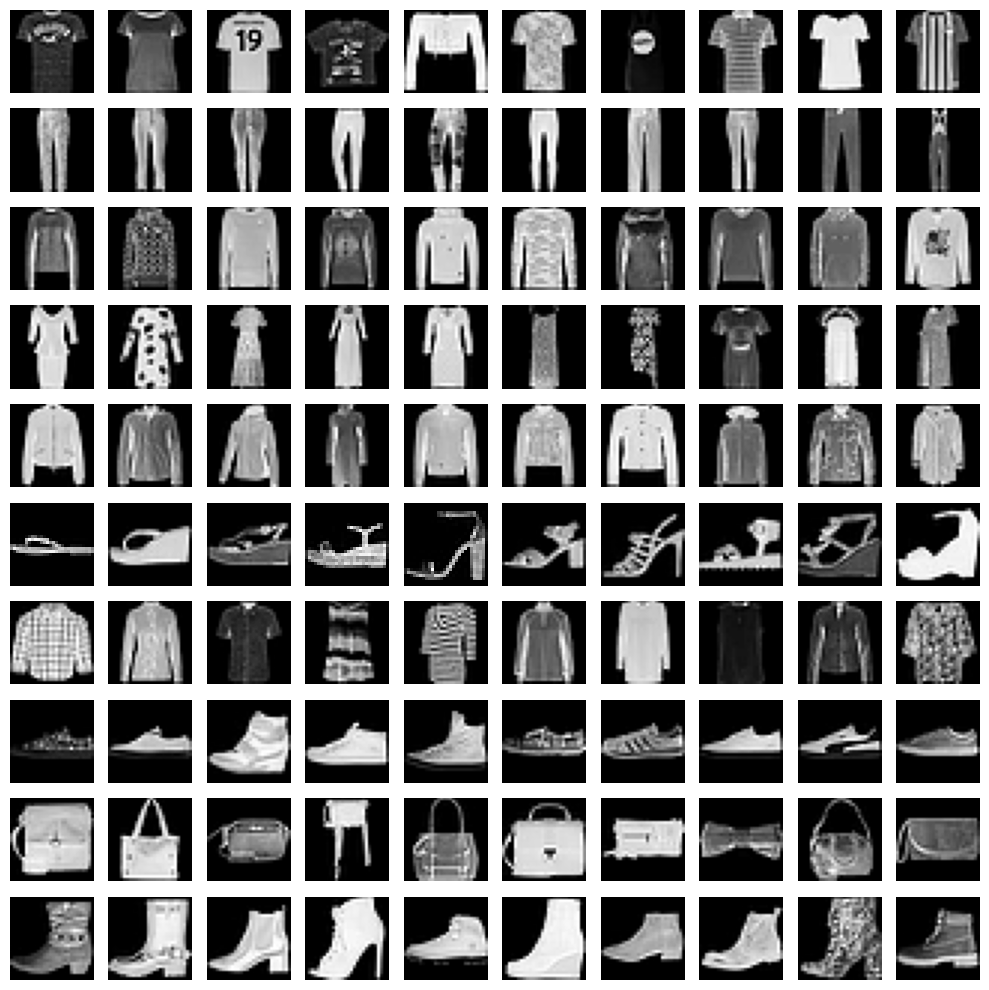

In [8]:
# plota uma imagem de cada classe
R, C = len(tr_targets.unique()), 10 # linhas R e colunas C = 10
fig, ax = plt.subplots(R, C, figsize=(10, 10)) # cria o template

for label_class, plot_row in enumerate(ax): # percorre as classes
    label_x_rows = np.where(tr_targets == label_class)[0]

    for plot_cell in plot_row: # percorre os blocos da linha
        plot_cell.grid(False)
        plot_cell.axis('off')
        ix = np.random.choice(label_x_rows) # random
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')

plt.tight_layout()

In [9]:
# converte as imagens pra tensor
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets

In [10]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28) # faz o flattening das imagens pra um vetor
        self.x, self.y = x, y # armazena os dados

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx] # acessa por fora no index
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)

In [12]:
def get_data(): # preparação dos dados
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [13]:
from torch.optim import SGD

def get_model():
    # cria um modelo sequencial com uma camada oculta de 1000 neurônios e ReLU
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()  # usa cross-entropy como função de perda
    optimizer = SGD(model.parameters(), lr=1e-2)  # usa SGD com taxa de aprendizado de 0.01

    return model, loss_fn, optimizer  # retorna o modelo, função de perda e otimizador


In [14]:
# desativa o cálculo do gradiente durante a avaliação
@torch.no_grad()

def accuracy(x, y, model):
    model.eval()
    prediction = model(x)  # faz a previsão com base nos dados de entrada
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y  # vê se tá correto

    # retorna a lista de acertos em formato numpy no cpu
    return is_correct.cpu().numpy().tolist()


In [15]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()  # modo de treino
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()

    opt.step()  # atualiza pesos
    opt.zero_grad()  # limpa gradientes

    return batch_loss.item()


In [16]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [17]:
# listas para armazenar a perda e acurácia por época
losses, accuracies = [], []

for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], [] # listas para armazenar perdas e acurácias da época

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn) # treina o modelo no batch atual e calcula a perda
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()  # média da perda da época

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model) # calcula a precisão do modelo para o batch atual
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)  # média da acurácia da época

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    # armazena os resultados da época


0
1
2
3
4


C:\Users\kaiqu\AppData\Local\Temp\ipykernel_884\1179357867.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


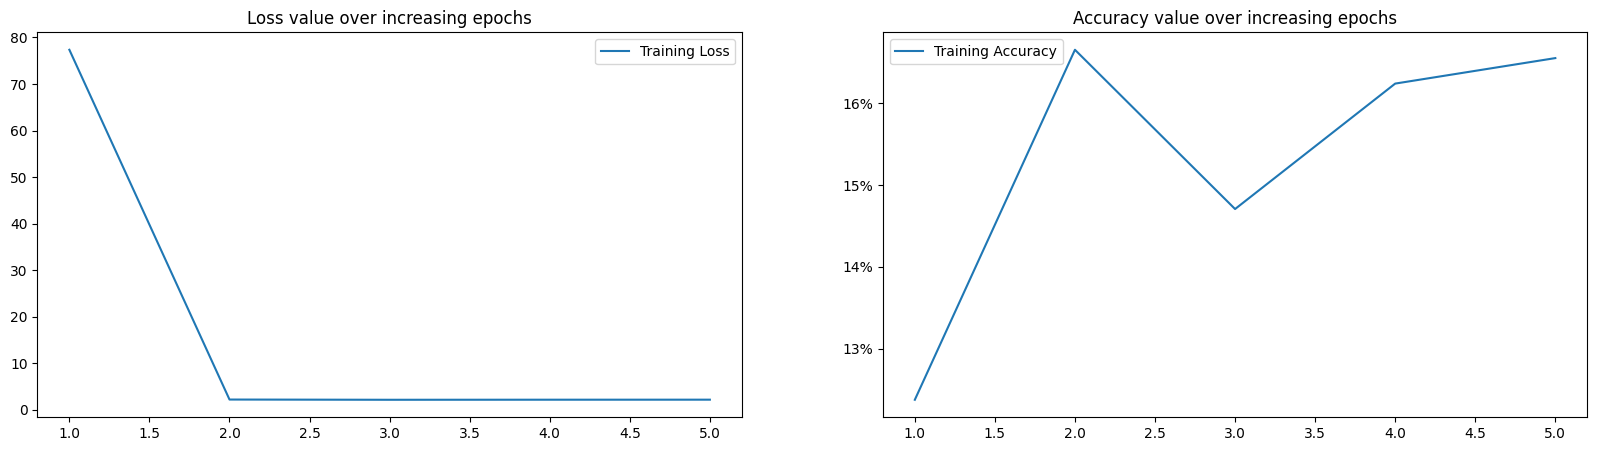

In [18]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))

# plot 1: perda
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()

# plot 2: precisão
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()